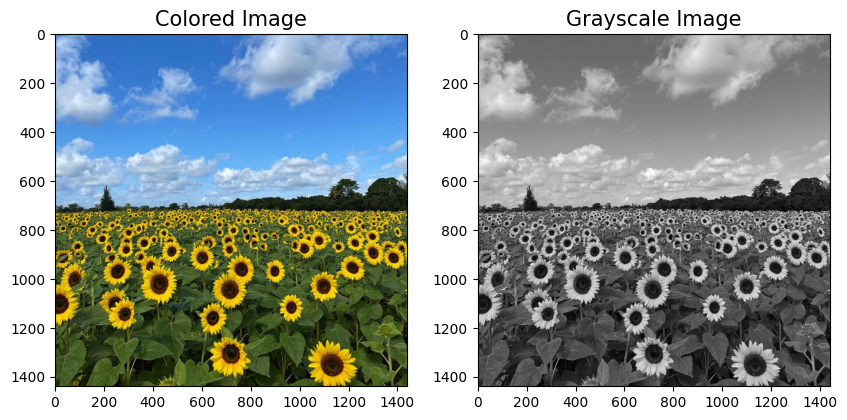

In [36]:
import numpy as np
from skimage.io import imshow, imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
sample = imread('the_berry_farms_sunflower_field.jpeg')
sample_g = rgb2gray(sample)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sample)
ax[1].imshow(sample_g,cmap='gray')
ax[0].set_title('Colored Image',fontsize=15)
ax[1].set_title('Grayscale Image',fontsize=15)
plt.show()

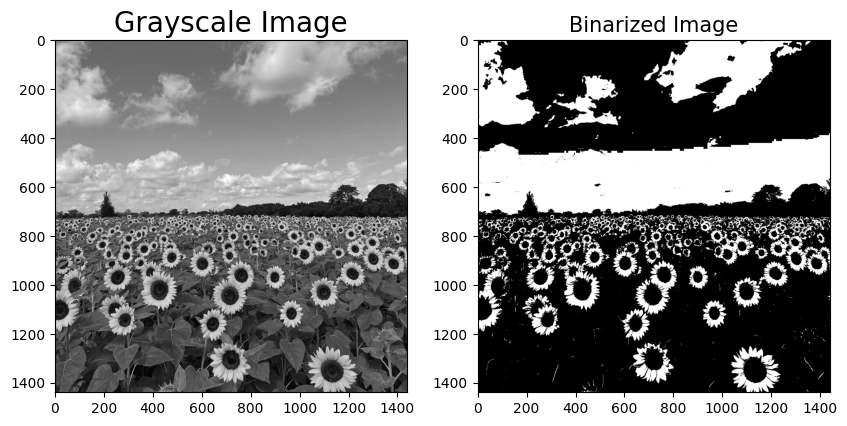

In [46]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sample_b = sample_g > 0.6
ax[0].set_title('Grayscale Image',fontsize=20)
ax[0].imshow(sample_g,cmap='gray')
ax[1].set_title('Binarized Image',fontsize=15)
ax[1].imshow(sample_b,cmap='gray')

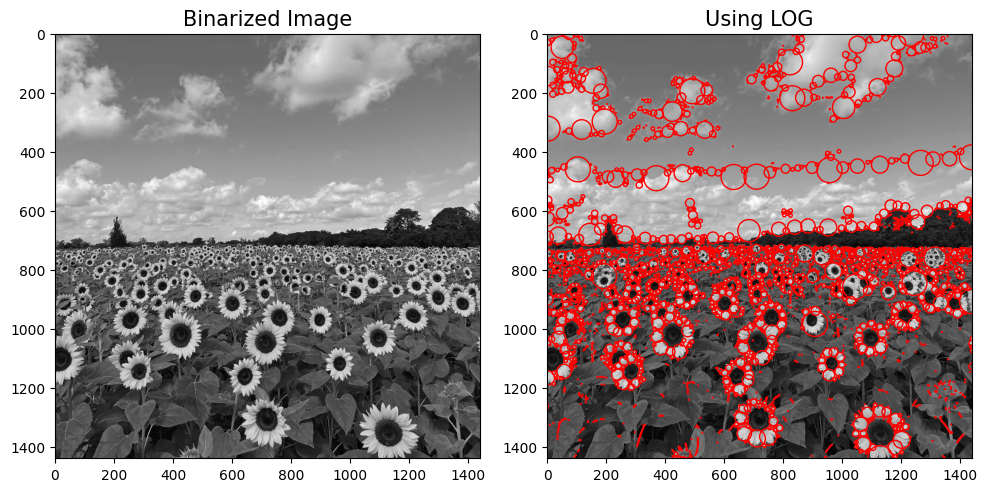

In [41]:
from skimage.feature import blob_dog, blob_log, blob_doh
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Binarized Image',fontsize=15)
ax[0].imshow(sample_g,cmap='gray')
blobs = blob_log(sample_b, max_sigma=30, threshold=0.01)
ax[1].imshow(sample_g, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax[1].add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', fill=False))
ax[1].set_title('Using LOG',fontsize=15)
plt.tight_layout()
plt.show()

# Question 2

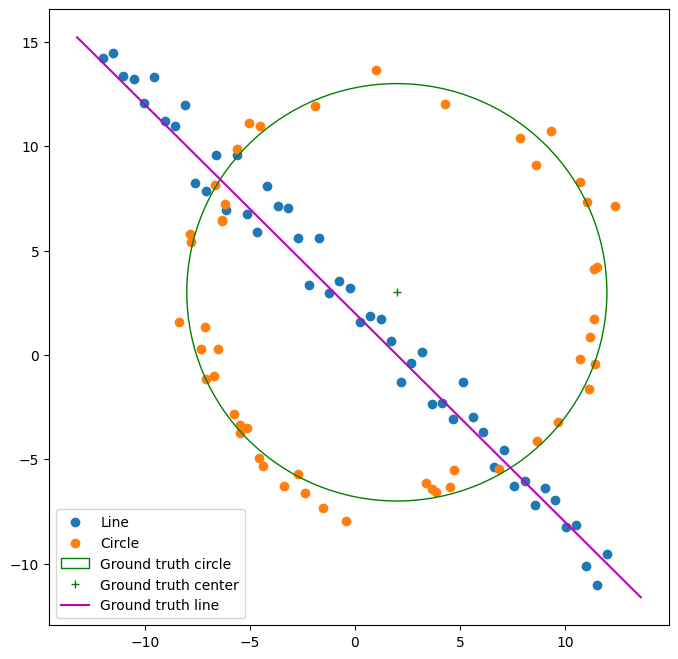

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b0 = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b0 + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

r_ground = r
# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b0
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

plt.show()

In [93]:
import math
from scipy.optimize import minimize

N = X.shape[0]
dataset = X

In [96]:
def line_equation_from_points(x1, y1, x2, y2):
    """ Return the line equation in the form ax + by = d"""
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    return a, b, d

def line_tls(x, indices):
    """ Return the total least squares error for the line model"""
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*dataset[indices,0] + b*dataset[indices,1] - d))

def g(x):
    """ Constraint """
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X, x, t):
    """ Computing the inliners """
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*dataset[:,0] + b*dataset[:,1] - d)
    return error < t

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.499631748762774e-08
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.458975213206894e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.330142015848532
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.910944943352291e-09
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.703491708644325e-10
            Iterations: 8
            Functio

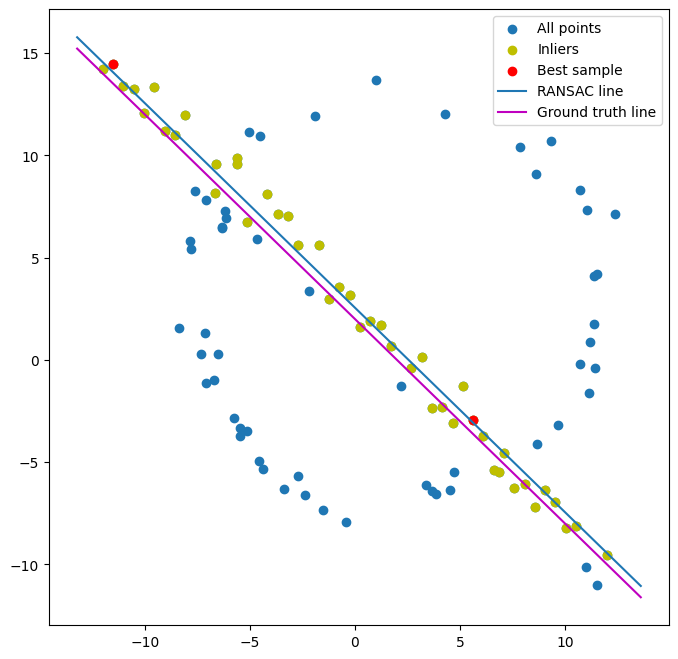

In [97]:
t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indices of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(dataset, res.x, t) # Computing the inliers
    #print('rex.x: ', res.x)    
    #print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        #print(res.x, res.fun)
        if res.fun < best_error:
            #print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = dataset[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

print(dataset.shape)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ran = np.array([x_min, x_max])
y_ran = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_ran, y_ran,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b0
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

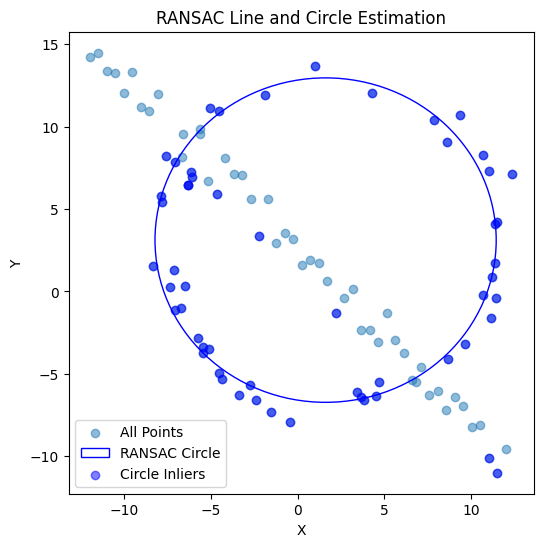

Estimated Circle Parameters: x=1.61, y=3.12, r=9.84


In [98]:
# Subtract the consensus of the best line (remnant)
line_inliers = dataset[best_inliers_line]
X_remnant = dataset[~best_inliers_line]

# RANSAC parameters for circle estimation
max_iterations_circle = 100
inlier_threshold_circle = 0.5  # Adjust this threshold as needed
min_inliers_circle = 3

def estimate_circle(points):
    # Define the objective function for circle fitting
    def circle_objective(params, points):
        x, y, r = params
        return np.sum((points[:, 0] - x)**2 + (points[:, 1] - y)**2 - r**2)**2

    # Initialize the optimizer with an initial guess for the circle parameters
    initial_guess = [2, 2, 5]  # Adjust the initial guess as needed
    result = minimize(circle_objective, initial_guess, args=(points,), method='Nelder-Mead')

    x, y, r = result.x
    return x, y, r

# Function to calculate the radial error (distance from points to the circle)
def circle_error(params, points):
    x, y, r = params
    distances = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)
    return distances

# RANSAC algorithm for circle estimation on the remnant
best_circle = None
best_inliers_circle = 0

for _ in range(max_iterations_circle):
    # Randomly select three points
    random_indices = np.random.choice(len(X_remnant), 3, replace=False)
    random_points = X_remnant[random_indices]

    # Estimate the circle parameters [x, y, r]
    x, y, r = estimate_circle(random_points)

    # Calculate the radial error (distance from points to the circle)
    errors = circle_error([x, y, r], X_remnant)

    # Count inliers (points that are within the threshold)
    inliers = np.sum(errors < inlier_threshold_circle)

    if inliers >= min_inliers_circle and inliers > best_inliers_circle:
        best_circle = [x, y, r]
        best_inliers_circle = inliers

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dataset[:, 0], dataset[:, 1], label='All Points', alpha=0.5)
circle = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], color='b', fill=False, label='RANSAC Circle')
ax.add_patch(circle)
ax.scatter(X_remnant[:, 0], X_remnant[:, 1], label='Circle Inliers', color='b', alpha=0.5)
ax.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('RANSAC Line and Circle Estimation')
plt.show()

# Print the estimated circle parameters
print(f'Estimated Circle Parameters: x={best_circle[0]:.2f}, y={best_circle[1]:.2f}, r={best_circle[2]:.2f}')

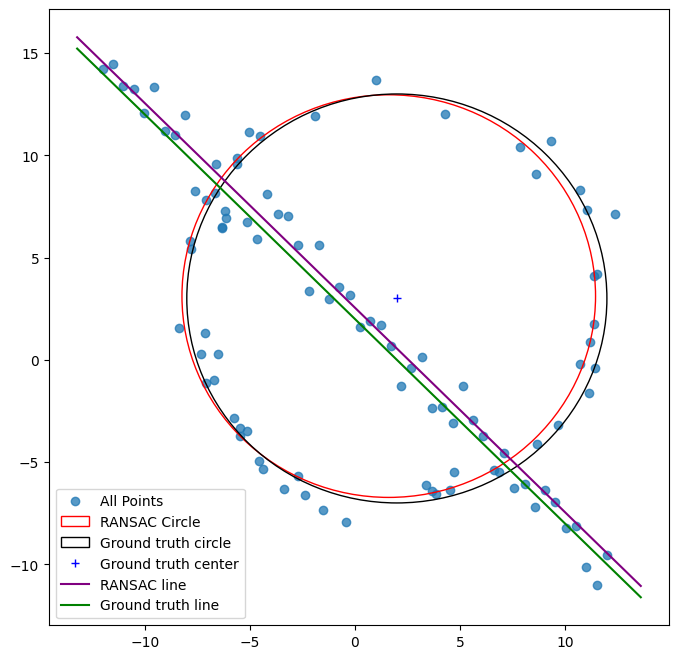

In [99]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(dataset[:, 0], dataset[:, 1], label='All Points', alpha = 0.75)
circle = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], color='r', fill=False, label='RANSAC Circle')
ax.add_patch(circle)

circle_gt = plt.Circle((x0_gt, y0_gt), r_ground, color='black', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+b', label='Ground truth center')

#ax.scatter(X_remnant[:, 0], X_remnant[:, 1], label='Circle Inliers', color='y')
plt.plot(x_ran, y_ran, color='purple', label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b0
plt.plot(x_, y_, color='green', label='Ground truth line')
plt.legend()
ax.legend()

# Question 3

In [161]:
import cv2
import numpy as np

# Function to handle mouse click events
def mouse_callback(event, x, y, flags, param):
    global points
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(points) < 4:
            points.append((x, y))
            cv2.circle(image_copy, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("Select Points", image_copy)
            if len(points) == 4:
                compute_homography()

# Function to compute homography and place the flag
def compute_homography():
    global points
    if len(points) == 4:
        architectural_points = np.array(points, dtype=np.float32)
        flag_points = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)
        homography_matrix, _ = cv2.findHomography(flag_points, architectural_points)
        flag_warped = cv2.warpPerspective(flag_image, homography_matrix, (image.shape[1], image.shape[0]))
        result = cv2.addWeighted(image, 1, flag_warped, 0.7, 0)
        cv2.imshow("Result", result)

# Load the architectural image and flag image
image = cv2.imread('background.jpeg')
flag_image = cv2.imread('flag.jpg')

image = cv2.resize(image, (1000, 600))

# Create a copy of the image for point selection
image_copy = image.copy()

# Create a window for point selection
cv2.namedWindow("Select Points")
cv2.setMouseCallback("Select Points", mouse_callback)

# List to store selected points
points = []

# Main loop
while True:
    cv2.imshow("Select Points", image_copy)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

cv2.destroyAllWindows()
